In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(0)

In [ ]:
tf = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Import data
train = datasets.get_coco(transform=tf)
test = datasets.get_coco(transform=tf, train=False)

reshape = nn.AvgPool2d(4)

# Get data parameters
N = len(train)
M = 384 * 384
Q = 96 * 96


# Set training parameters and loader
batch_size = 32
epochs = 8
nu = 0.0005
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'pie_dense_superres_patch'

In [ ]:
# Test with other patch dimensions for better results?
patch_dims =     [256, 256, 256, 256, 256]
grid_dims_pie =  [576, 484, 361, 196,  36]
grid_dims_ae  =  [576, 225, 144,  64,  36]

model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device,
}

nets = {
    "PIE": models.dense.AdjointDenseMixer(
        patch_dims,
        grid_dims_pie,
        diagonal=True,
        init=nn.init.orthogonal_,
        **model_kwargs,
    ),
    "AE": models.dense.AEDenseMixer(
        patch_dims,
        grid_dims_ae,
        diagonal=False,
        **model_kwargs,
    ),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)


# Generate winsplit
split = modules.AdjointSequential(
    modules.AdjointPatchSplitter((24,24), (16,16)),
    modules.AdjointFlatten(-2, -1, (24,24))
)

splitsmall = modules.AdjointSequential(
    modules.AdjointPatchSplitter((6,6), (16,16)),
    modules.AdjointFlatten(-2, -1, (6,6))
)

In [5]:
# Define objective function

def objective_function(x, xh, y, yh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}
    
    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    kwargs = {'reduction': reduction}    
    kwargs['alpha'] = 5.0

    losses['lx'] = utils.loss.logcosh(xh, x, **kwargs)
    losses['ly'] = utils.loss.logcosh(yh, y, **kwargs)
#     losses['ls'] = 0.1 * utils.loss.logcosh(
#         splitsmall.T(yh) - reshape(split.T(x)), 
#         splitsmall.T(y) - reshape(split.T(xh)), 
#         **kwargs
#     )
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [6]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params PIE     :  1069628
No. params AE      :  1111456


In [7]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.cat([train[k] for k in sample_indices_small])
ys = splitsmall(reshape(xims)).to(device)
xs = split(xims).to(device)


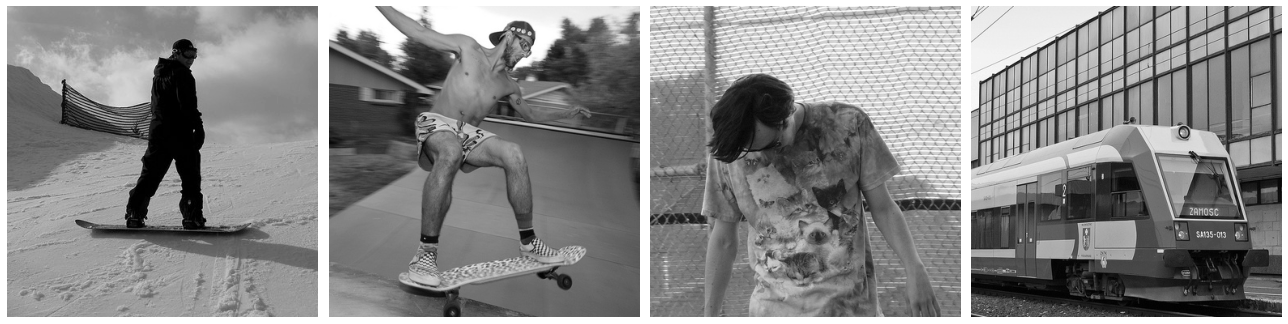

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(18,8))
for i in range(4):
    ax[i].imshow(xims[i], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

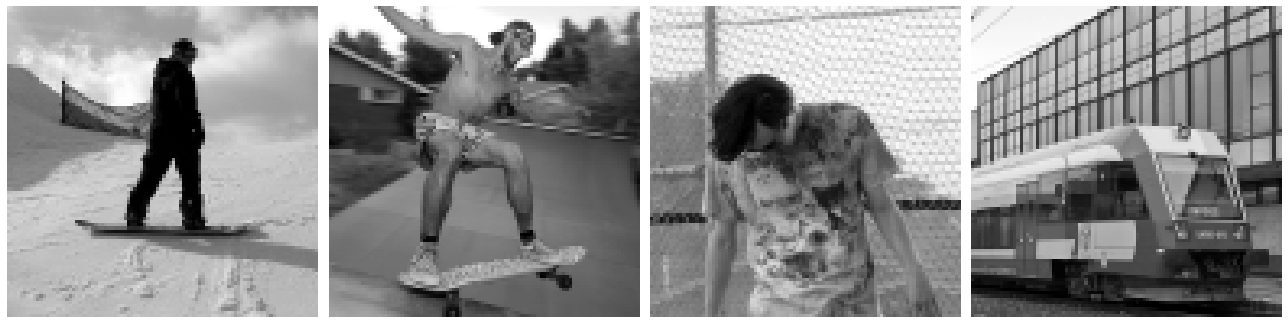

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(18,8))
for i in range(4):
    ax[i].imshow(reshape(xims[i][None,...])[0], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

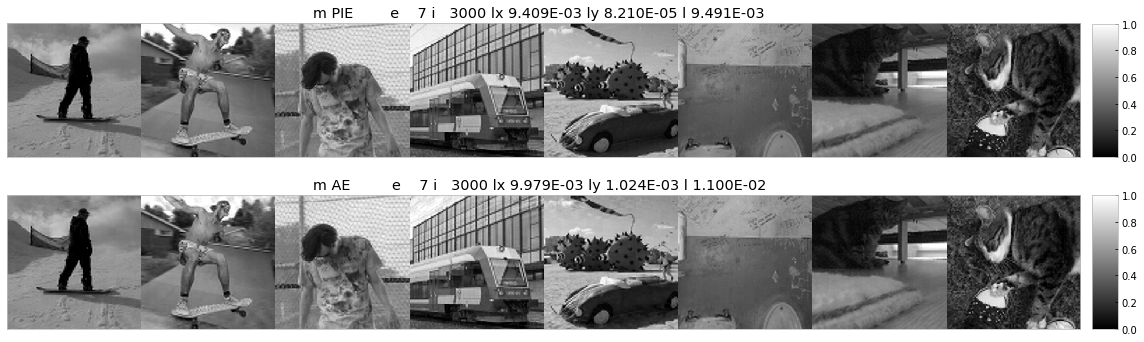

In [10]:
# Training loop

for e in range(epochs):
    i = 0
    for x in loader:
        y = splitsmall(reshape(x.to(device))).detach()
        x = split(x.to(device))
                
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()            
            yh = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, y, yh)

            loss.backward()
            opts[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 25 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    xhs[cur] = split.T(
                        nets[cur].T(ys)
                    ).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name, save=(i % 50 == 0), cmap='gray')
            
        i += 1

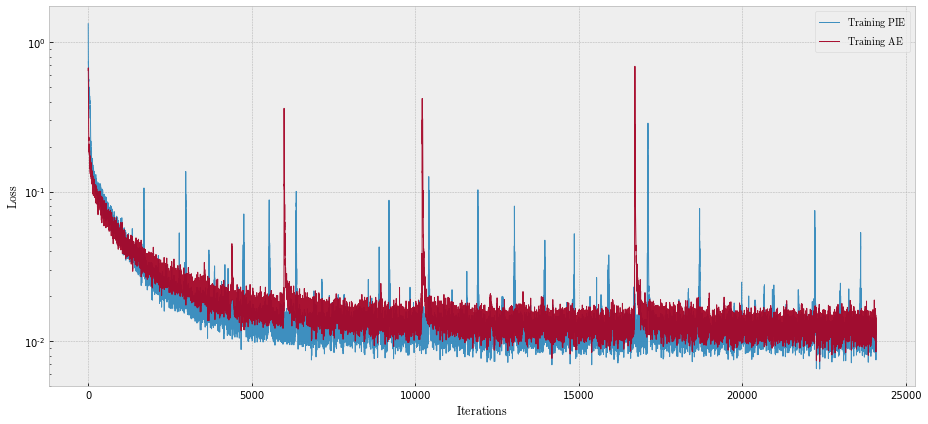

In [11]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    plt.plot(np_loss_trace[k]["l"], linewidth=1, label=f"$\mathrm{{Training\,\,{k}}}$", alpha=0.95)

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
#plt.ylim(0.005, 0.05)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

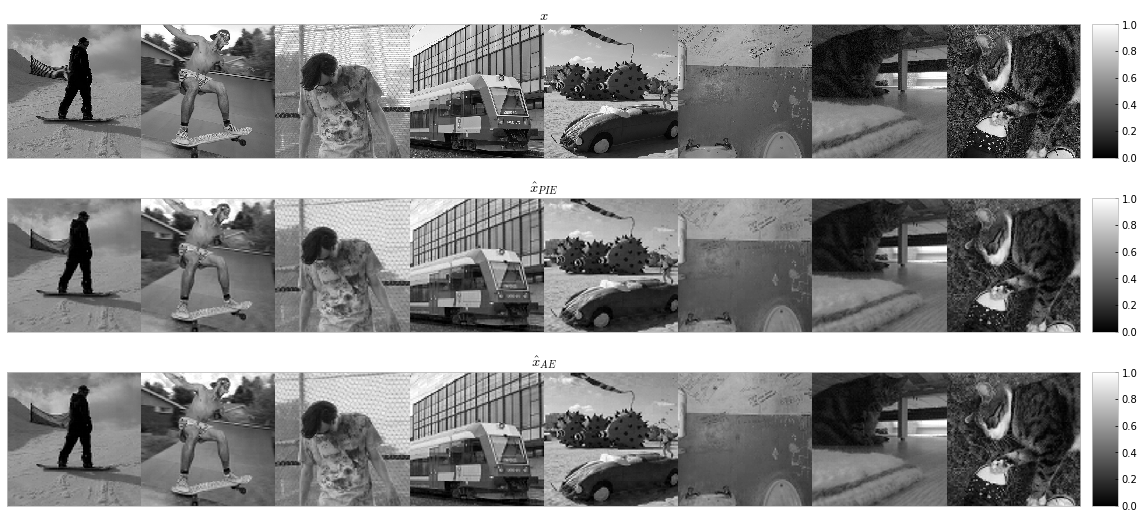

In [12]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to(device)
    
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = split.T(nets[cur].T(ys)).cpu()
    
utils.reporting.plot_results(xhs, '', fname=experiment_name, cmap='gray')

In [13]:
example = 6888

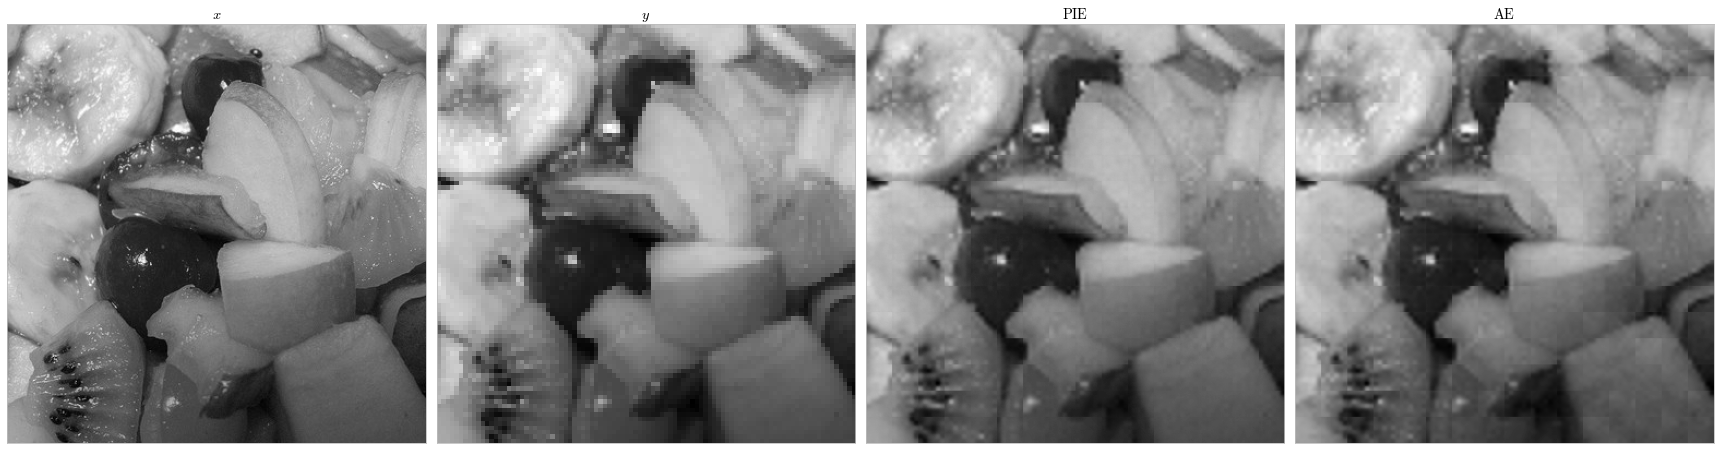

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(24,10))

ax[0].imshow(train[example][0], cmap='gray')
ax[0].set_title('$x$')
ax[1].imshow(reshape(train[example])[0], cmap='gray')
ax[1].set_title('$y$')


for i, cur in enumerate(nets):
    with torch.no_grad():
        xh = nets[cur].T(
            nets[cur](
                split(train[example]).to(device)
            )
        )

    ax[i+2].imshow(
        split.T(xh).cpu()[0],
        cmap='gray'
    )
    ax[i+2].set_title(f'$\mathrm{{{cur}}}$')
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

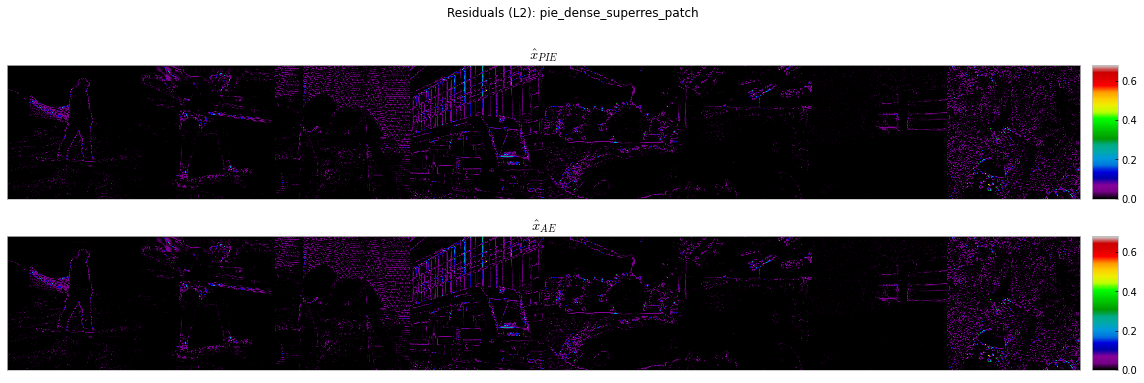

In [16]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = split.T(nets[cur].T(ys)).cpu()
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [17]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [18]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [19]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [22]:
# Compute test tensor

test_tensor = []
for i in tqdm(range(len(test))):
    test_tensor.append(test[i])
    
test_tensor = split(torch.cat(test_tensor))

  0%|          | 0/4002 [00:00<?, ?it/s]

In [28]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        xth = model.T(model(test_tensor))
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(split.T(xth).flatten(-1), split.T(test_tensor).flatten(-1), reduction='mean'):4E} " +
        f"MSE {F.mse_loss(split.T(xth).flatten(-1), split.T(test_tensor).flatten(-1), reduction='mean'):4E} "
    )

Relative Error:
PIE   : RE 1.479937E-01 MSE 5.373115E-03 
AE    : RE 1.575646E-01 MSE 5.863802E-03 


In [29]:
import gc

del xth
gc.collect();

In [30]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(model(test_tensor))
        psnr = utils.metrics.psnr(test_tensor, XH)
        ssim = utils.metrics.ssim(
            split.T(test_tensor)[:,None,...], 
            split.T(XH)[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

# Clear memory
del XH
gc.collect();

Image Reconstruction Metrics:
PIE   : PSNR 2.269774E+01 SSIM 6.710315E-01 
AE    : PSNR 2.231821E+01 SSIM 6.493134E-01 


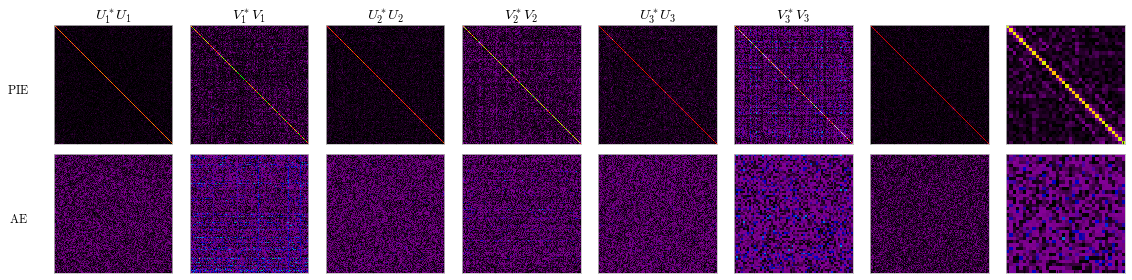

In [43]:
fig, ax = plt.subplots(2, 8, figsize=(16,4))
plotkwargs = {'vmin': 0, 'vmax': 1}
for i,cur in enumerate(nets):    
    if cur == 'PIE':
        U1 = nets[cur].net.V.affine.W.weight_U.detach().cpu()
        V1 = nets[cur].net.V.affine.W.weight_V.detach().cpu()
        U2 = nets[cur].net.W1.affine.W.weight_U.detach().cpu()
        V2 = nets[cur].net.W1.affine.W.weight_V.detach().cpu()
        U3 = nets[cur].net.W2.affine.W.weight_U.detach().cpu()
        V3 = nets[cur].net.W2.affine.W.weight_V.detach().cpu()
        U4 = nets[cur].net.U.affine.W.weight_U.detach().cpu()
        V4 = nets[cur].net.U.affine.W.weight_V.detach().cpu()
        U1T = U1.T
        U2T = U2.T
        U3T = U3.T
        U4T = U4.T
        V1T = V1.T
        V2T = V2.T
        V3T = V3.T
        V4T = V4.T
        
    else:
        U1 = nets[cur].net_fwd.V.affine.W.weight_U.detach().cpu()
        V1 = nets[cur].net_fwd.V.affine.W.weight_V.detach().cpu()
        U2 = nets[cur].net_fwd.W1.affine.W.weight_U.detach().cpu()
        V2 = nets[cur].net_fwd.W1.affine.W.weight_V.detach().cpu()
        U3 = nets[cur].net_fwd.W2.affine.W.weight_U.detach().cpu()
        V3 = nets[cur].net_fwd.W2.affine.W.weight_V.detach().cpu()
        U4 = nets[cur].net_fwd.U.affine.W.weight_U.detach().cpu()
        V4 = nets[cur].net_fwd.U.affine.W.weight_V.detach().cpu()

        U1T = nets[cur].net_bck.V.affine.W.weight_U.detach().cpu().T
        V1T = nets[cur].net_bck.V.affine.W.weight_V.detach().cpu().T
        U2T = nets[cur].net_bck.W1.affine.W.weight_U.detach().cpu().T
        V2T = nets[cur].net_bck.W1.affine.W.weight_V.detach().cpu().T
        U3T = nets[cur].net_bck.W2.affine.W.weight_U.detach().cpu().T
        V3T = nets[cur].net_bck.W2.affine.W.weight_V.detach().cpu().T
        U4T = nets[cur].net_bck.U.affine.W.weight_U.detach().cpu().T
        V4T = nets[cur].net_bck.U.affine.W.weight_V.detach().cpu().T


    ax[i,0].matshow(torch.abs(U1T @ U1),**plotkwargs)
    ax[i,1].matshow(torch.abs(V1T @ V1),**plotkwargs)
    ax[i,2].matshow(torch.abs(U2T @ U2),**plotkwargs)
    ax[i,3].matshow(torch.abs(V2T @ V2),**plotkwargs)
    ax[i,4].matshow(torch.abs(U3T @ U3),**plotkwargs)
    ax[i,5].matshow(torch.abs(V3T @ V3),**plotkwargs)
    ax[i,6].matshow(torch.abs(U4T @ U4),**plotkwargs)
    ax[i,7].matshow(torch.abs(V4T @ V4),**plotkwargs)
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(top=False, left=False, labelleft=False, labeltop=False)
    
cols = sum([[f'$U_{i}^* U_{i}$', f'$V_{i}^* V_{i}$'] for i in range(1,3+1)], [])

for a, c in zip(ax[0], cols):
    a.set_title(c)

for a, r in zip(ax[:,0], nets.keys()):
    a.set_ylabel(f'$\mathrm{{{r}}}$', rotation=0, size='large')
    a.yaxis.set_label_coords(-.3,.4)
    
plt.savefig(f'../figures/misc/{experiment_name}_gramians.pdf')

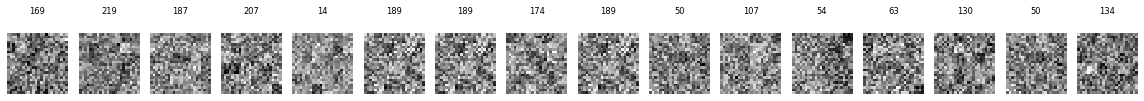

In [48]:
indices = [
    327, 133, 347, 278, 335, 48, 371, 406, 
    223, 172, 15, 318, 249, 349, 46, 160,
]

indices = np.random.randint(len(V1.T), size=16)

fig, ax = plt.subplots(1, 16, figsize=(16,2))
for i in range(len(ax)):    
    ax[i].matshow(V1[:,indices[i]].unflatten(-1, (24, 24)), cmap='gray')
    ax[i].set_title(str(indices[i]), size='small')
    ax[i].axis('off');
    
plt.savefig(f'../figures/misc/{experiment_name}_dictvectors.pdf')

In [49]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(256, 576).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [ ]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    lphiy = -F.mse_loss(xe, xh)
    losses['lphix'] = lphix
    losses['lphiy'] = lphiy

    return sum(losses.values()), losses

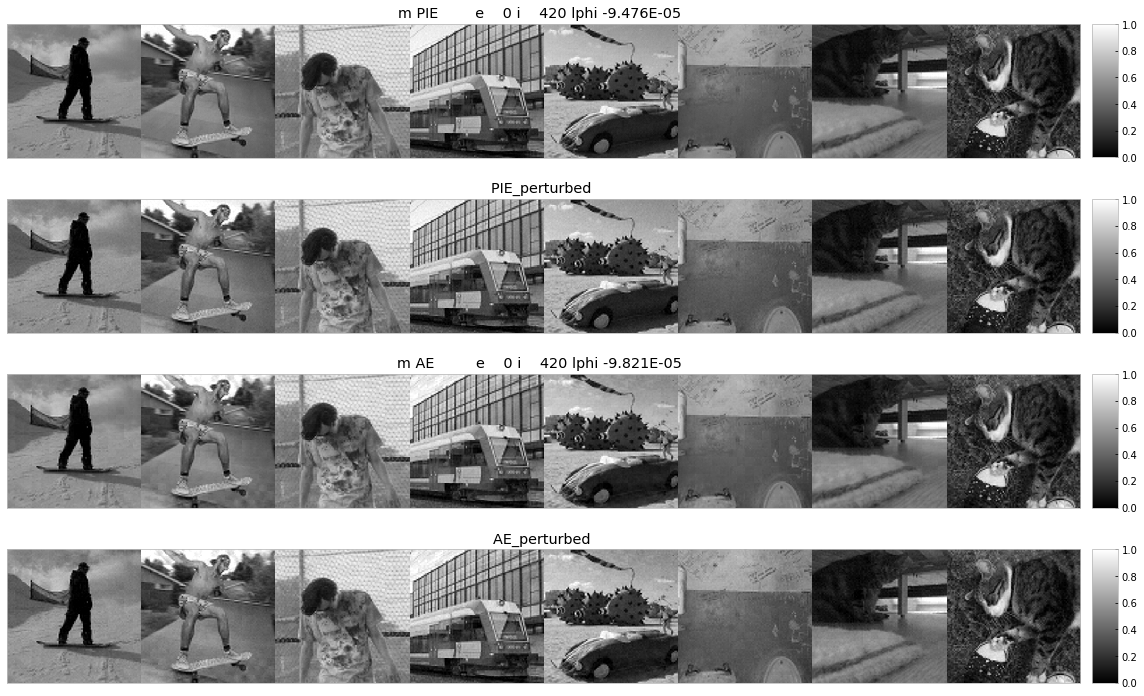

KeyboardInterrupt: 

In [52]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = splitsmall(reshape(x.to(device))).detach()
        x = split(x.to(device))
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur].T(nets[cur](x))
            xe = nets[cur].T(nets[cur](x + r))

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = split.T(nets[cur].T(nets[cur](xs))).cpu()
                    xhs[per] = split.T(nets[cur].T(nets[cur](xs + r))).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [208]:
r.shape

torch.Size([256, 576])

In [213]:
winunsplit(r[None,...].unflatten(-1, (24, 24))).shape

torch.Size([1, 384, 384])

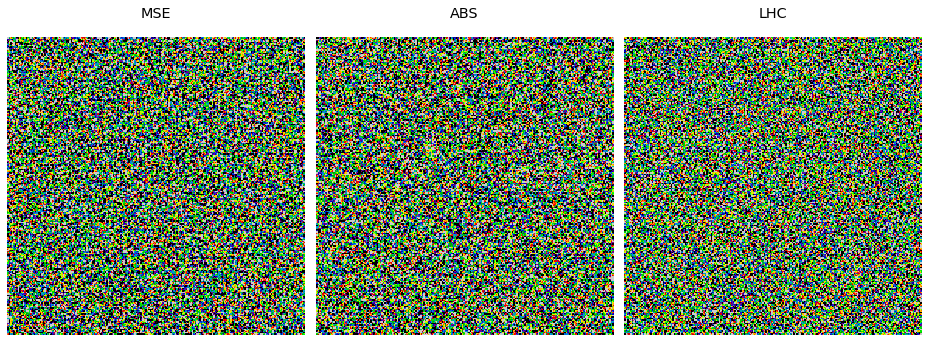

In [218]:
fig, ax = plt.subplots(1, 3)
for i, (k, r) in enumerate(rs.items()):
    ax[i].matshow(
        winunsplit(r[None,...].unflatten(-1, (24, 24)).to('cpu').detach())[0], 
        vmin=-1, 
        vmax=1
    )
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].set_title(k)

plt.savefig(f'../figures/misc/{experiment_name}_perturbationvecs.pdf')

In [219]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Error:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
        XE = model.T(model(test_tensor + r))

    print(f"{k:6}: {utils.metrics.relative_error(test_tensor + rs[k].cpu(), XE, reduction='mean')}")

print(f"Relative Cond:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
        XE = model.T(model(test_tensor + r))
        XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor, test_tensor + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH, XE, test_tensor, r, reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Error:
MSE   : 0.8780869841575623
ABS   : 0.8664236664772034
LHC   : 0.8488733172416687
Relative Cond:
MSE   : 0.139082 0.172462 6.919789
ABS   : 0.144001 0.172462 7.162640
LHC   : 0.180445 0.172462 8.994296


In [12]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [15]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)